In [1]:
import json
import torch
import ast
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append('..')
# from auto_eval_utils import registered_simple_metrics, registered_helpers
from model import HeadOutputs
from datasets import load_from_disk, Dataset
from tqdm import tqdm
from visualize_eval import *

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

/home/evanfrick/chrono_training_code/p2l/.env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-05-17 02:06:37,885] [WARNING] [real_accelerator.py:174:get_accelerator] Setting accelerator to CPU. If you have GPU or other accelerator, we were unable to detect it.
[2025-05-17 02:06:37,889] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cpu (auto detect)


df: /home/evanfrick/.triton/autotune: No such file or directory
/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


In [3]:
with open('/tmp/timestamps/val_timestamps.json', 'r') as file:
    timestamps = json.load(file)

In [ ]:
def plot_training_strategies_comparison(paths_with_labels, title='Comparison of Training Strategies on Chronological Val Data', ncols = 4, baseline=None, ax=None, fontsize=24):
    plt.style.use('seaborn-v0_8-muted')

    ax_given = ax is not None

    if not ax_given:
        fig, ax = plt.subplots(figsize=(16, 12))

    if baseline:
        with open(baseline, 'r') as file:
            data = json.load(file)

            data_int = {int(k): {int(inner_k): v for inner_k, v in inner_dict.items()} for k, inner_dict in data.items()}

            last_model_cp = max(data_int.keys())

            performance = data_int[last_model_cp]
            
            performance_series = pd.Series(performance).sort_index()

            baseline = performance_series



    for path, label in paths_with_labels:
        with open(path, 'r') as file:
            data = json.load(file)

        data_int = {int(k): {int(inner_k): v for inner_k, v in inner_dict.items()} for k, inner_dict in data.items()}

        last_model_cp = max(data_int.keys())
        if last_model_cp not in data_int:
            continue

        performance = data_int[last_model_cp]
        
        performance_series = pd.Series(performance).sort_index()

        if baseline is not None:
            performance_series = performance_series - baseline
        
        x_vals = [pd.to_datetime(timestamps[str(val)]['end_tstamp'], unit='s') for val in performance_series.index]
        
        if 'Shuffled Training (Oracle)' in label:
            
            ax.plot(
                x_vals,
                performance_series.values,
                marker='o',
                linewidth=2,
                linestyle='--',
                label=label,
                color='gray'
            )
        else:
            ax.plot(
                x_vals,
                performance_series.values,
                marker='o',
                linewidth=2,
                linestyle="-",
                label=label
            )

    ax.set_xlabel('Timestamp', fontsize=fontsize, labelpad=4)
    ax.set_ylabel('Loss', fontsize=fontsize, labelpad=4)

    ax.tick_params(axis='both', which='major', labelsize=fontsize)

    ax.set_ylim((1.13, 1.30))


    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.1),
        ncol=ncols,
        fontsize=fontsize,
        title='Training Strategy',
        title_fontsize=fontsize,
        frameon=False
    )

    if not ax_given:

        fig.tight_layout()
        plt.show()


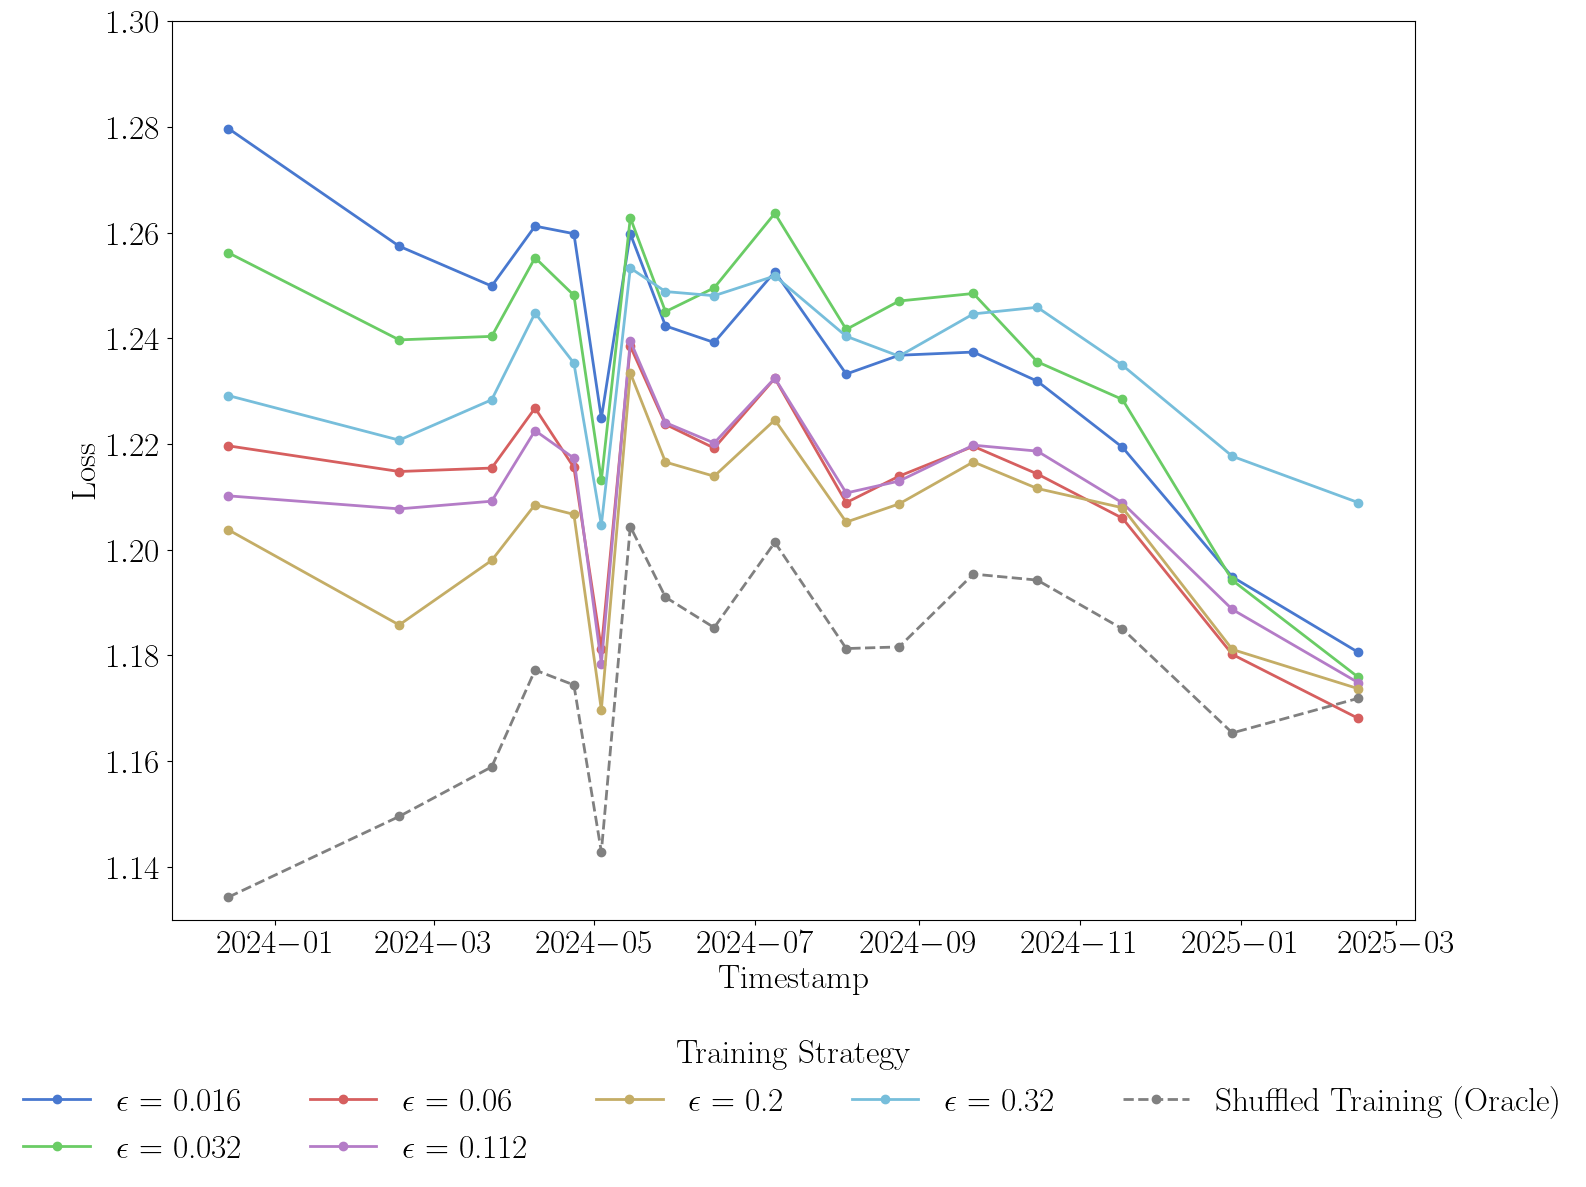

In [65]:
plot_training_strategies_comparison(
    paths_with_labels= [
        ('/tmp/checkpoint_results2/loss/output_eps_0.016.json', '$\epsilon$ = 0.016'),
        ('/tmp/checkpoint_results2/loss/output_eps_0.032.json', '$\epsilon$ = 0.032'),
        ('/tmp/checkpoint_results2/loss/output_eps_0.06.json', '$\epsilon$ = 0.06'),
        ('/tmp/checkpoint_results2/loss/output_eps_0.112.json', '$\epsilon$ = 0.112'),
        ('/tmp/checkpoint_results2/loss/output_eps_0.2.json', '$\epsilon$ = 0.2'),
        ('/tmp/checkpoint_results2/loss/output_eps_0.32.json', '$\epsilon$ = 0.32'),
        ('checkpoint_results/shuffled_cp_results.json', 'Shuffled Training (Oracle)'),
    ],
    title = 'Comparison of Replay Buffer Performance on Chronological Validation Data',
    ncols = 5
)

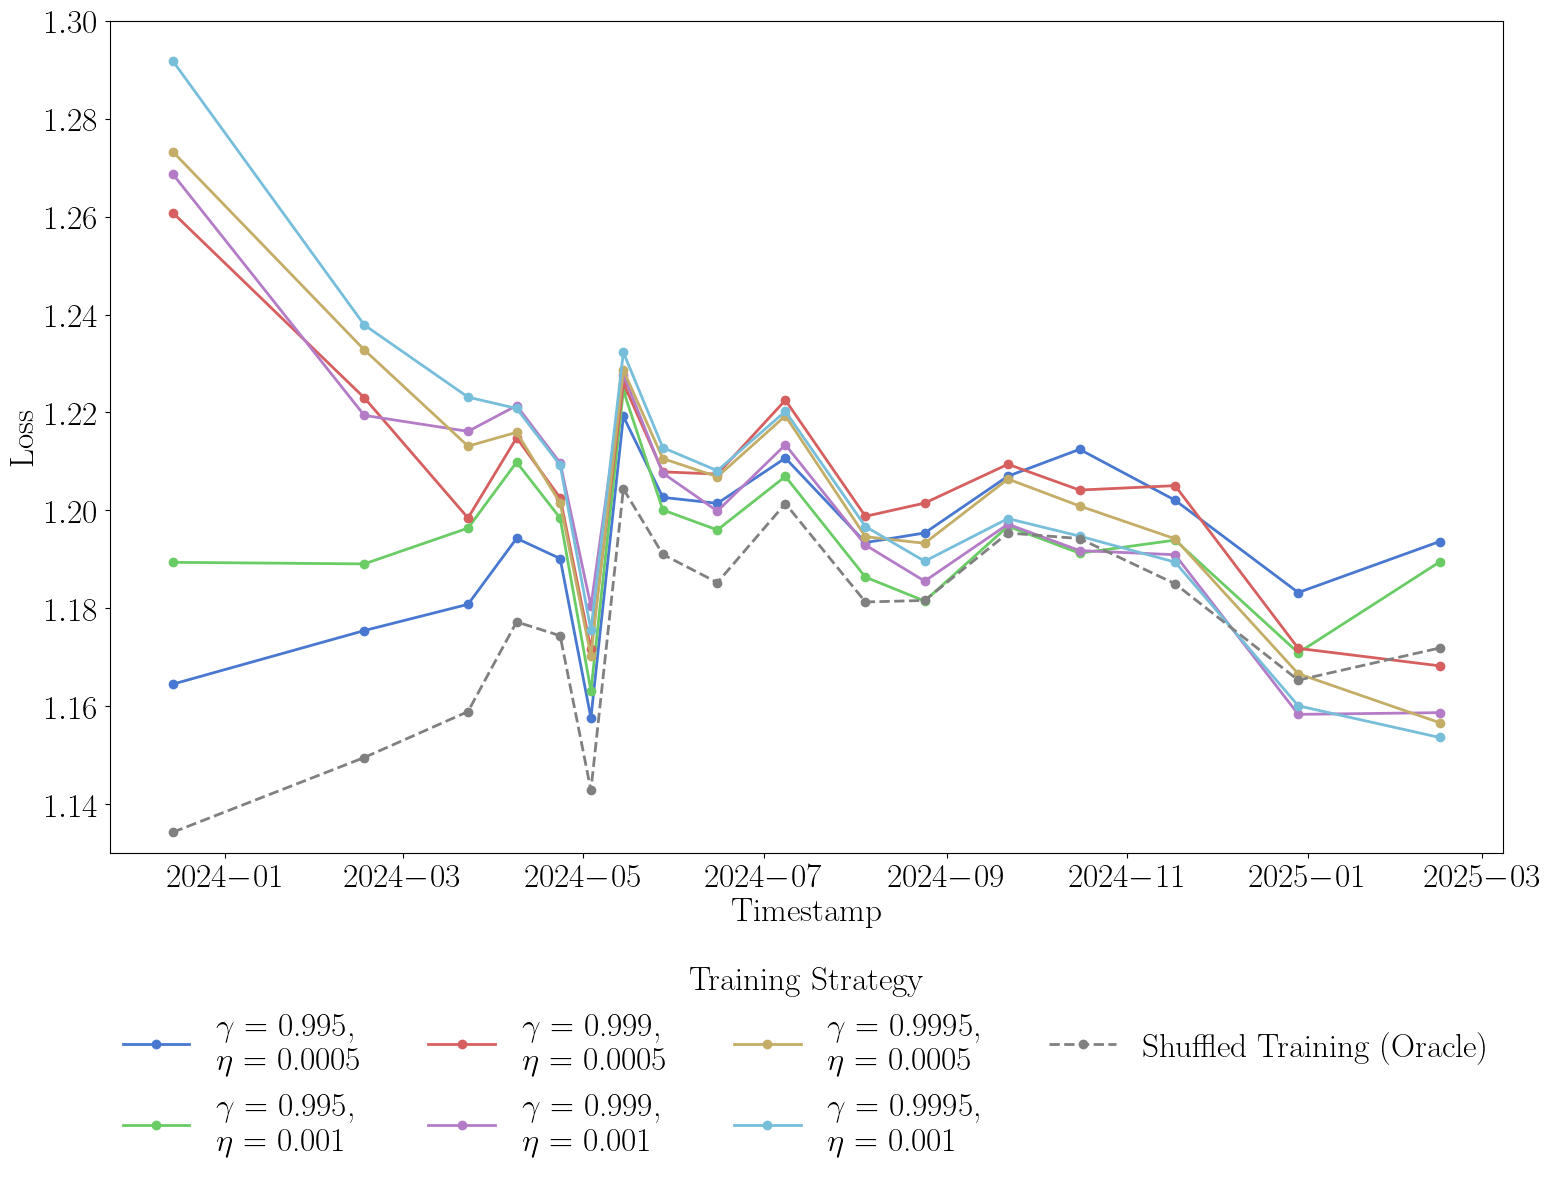

In [66]:
plot_training_strategies_comparison(
    paths_with_labels= [
        ('/tmp/checkpoint_results2/loss/output-geom-0.995-0.0005.json', '$\gamma$ = 0.995,\n$\eta$ = 0.0005'),
        ('/tmp/checkpoint_results2/loss/output-geom-0.995-0.001.json', '$\gamma$ = 0.995,\n$\eta$ = 0.001'),
        ('/tmp/checkpoint_results2/loss/output-geom-0.999-0.0005.json', '$\gamma$ = 0.999,\n$\eta$ = 0.0005'),
        ('/tmp/checkpoint_results2/loss/output-geom-0.999-0.001.json', '$\gamma$ = 0.999,\n$\eta$ = 0.001'),
        ('/tmp/checkpoint_results2/loss/output-geom-0.9995-0.0005.json', '$\gamma$ = 0.9995,\n$\eta$ = 0.0005'),
        ('/tmp/checkpoint_results2/loss/output-geom-0.9995-0.001.json', '$\gamma$ = 0.9995,\n$\eta$ = 0.001'),

        ('checkpoint_results/shuffled_cp_results.json', 'Shuffled Training (Oracle)'),

    ],
    
    title = 'Comparison of Geometric Buffer Performance on Chronological Validation Data',

)

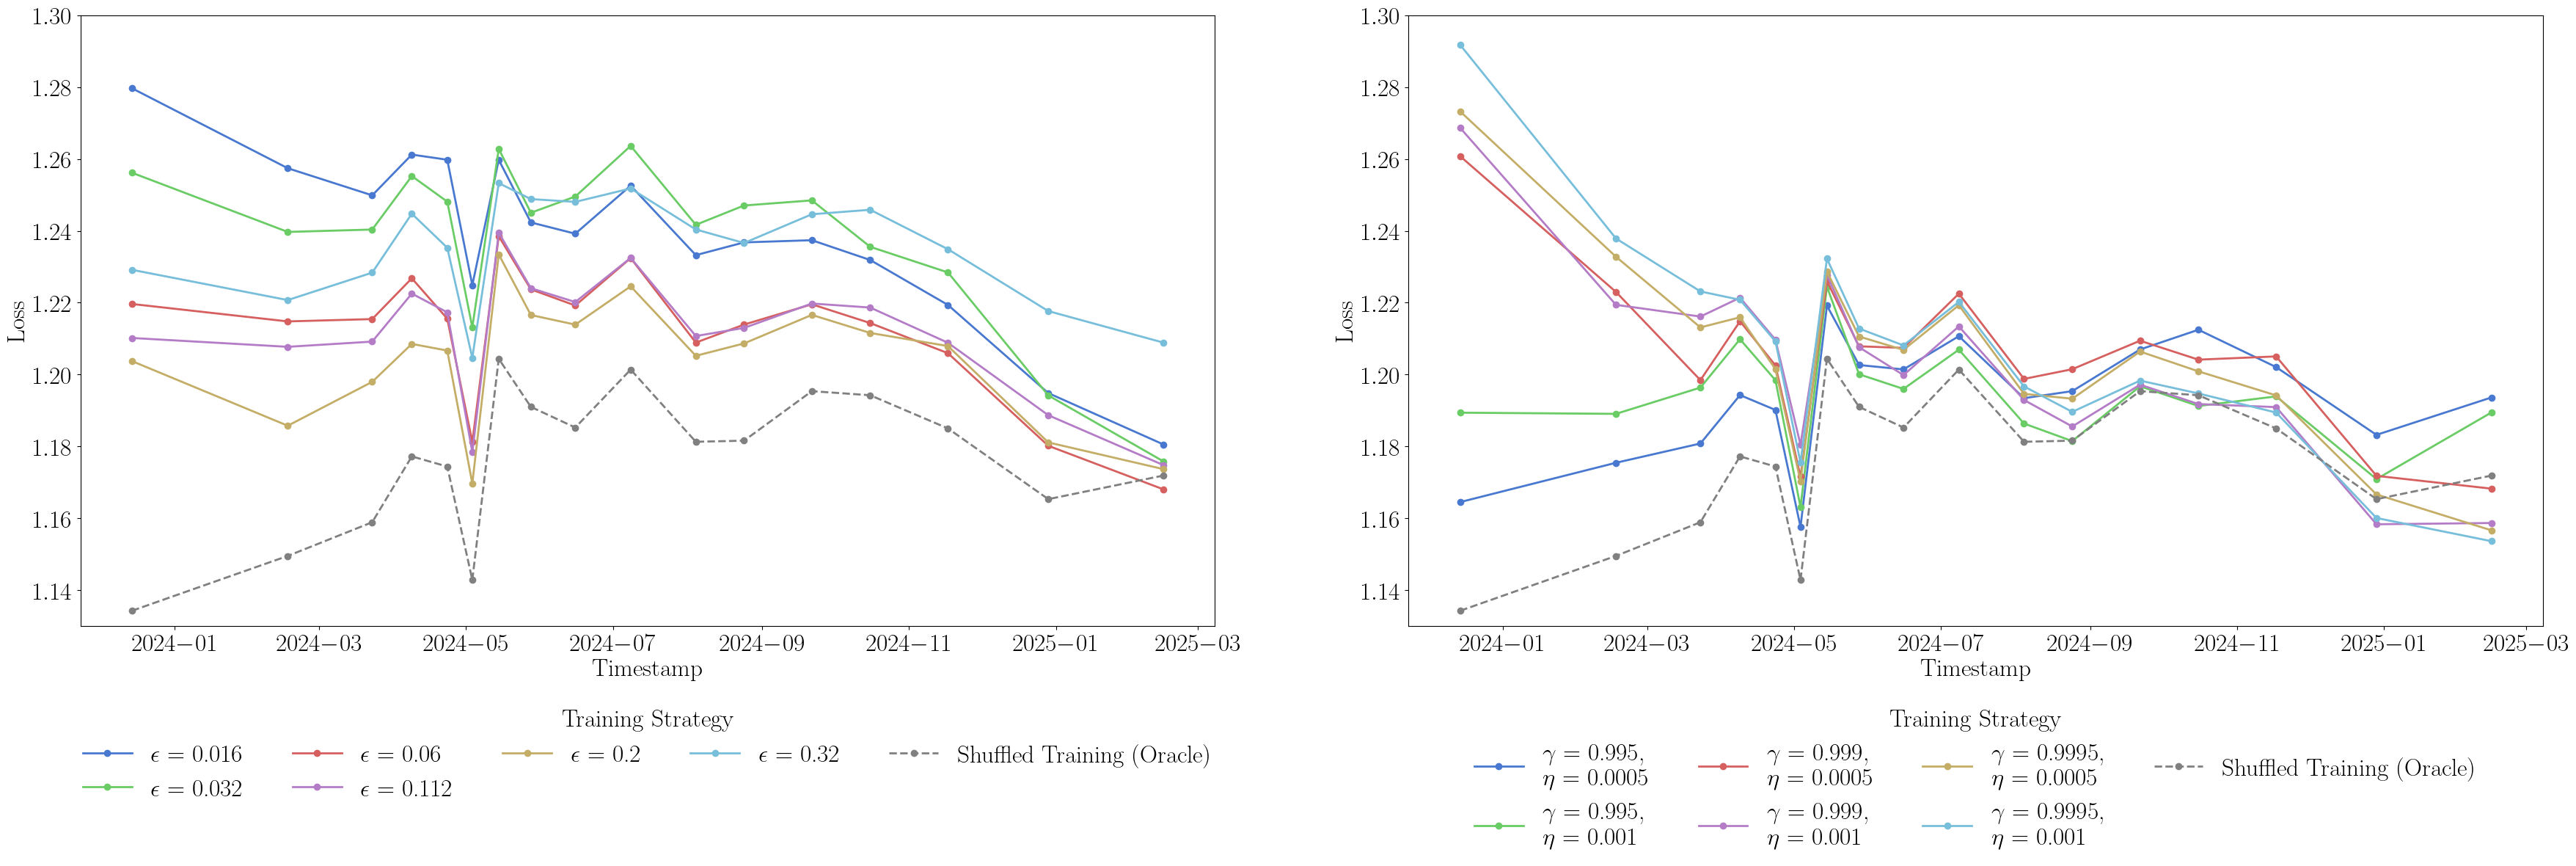

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(36, 12))

axes = axes.flatten()

plot_training_strategies_comparison(
    paths_with_labels= [
        ('/tmp/checkpoint_results2/loss/output_eps_0.016.json', '$\epsilon$ = 0.016'),
        ('/tmp/checkpoint_results2/loss/output_eps_0.032.json', '$\epsilon$ = 0.032'),
        ('/tmp/checkpoint_results2/loss/output_eps_0.06.json', '$\epsilon$ = 0.06'),
        ('/tmp/checkpoint_results2/loss/output_eps_0.112.json', '$\epsilon$ = 0.112'),
        ('/tmp/checkpoint_results2/loss/output_eps_0.2.json', '$\epsilon$ = 0.2'),
        ('/tmp/checkpoint_results2/loss/output_eps_0.32.json', '$\epsilon$ = 0.32'),
        ('checkpoint_results/shuffled_cp_results.json', 'Shuffled Training (Oracle)'),
    ],
    title = 'Comparison of Replay Buffer Performance on Chronological Validation Data',
    ncols = 5,
    ax=axes[0]
)

plot_training_strategies_comparison(
    paths_with_labels= [
        ('/tmp/checkpoint_results2/loss/output-geom-0.995-0.0005.json', '$\gamma$ = 0.995,\n$\eta$ = 0.0005'),
        ('/tmp/checkpoint_results2/loss/output-geom-0.995-0.001.json', '$\gamma$ = 0.995,\n$\eta$ = 0.001'),
        ('/tmp/checkpoint_results2/loss/output-geom-0.999-0.0005.json', '$\gamma$ = 0.999,\n$\eta$ = 0.0005'),
        ('/tmp/checkpoint_results2/loss/output-geom-0.999-0.001.json', '$\gamma$ = 0.999,\n$\eta$ = 0.001'),
        ('/tmp/checkpoint_results2/loss/output-geom-0.9995-0.0005.json', '$\gamma$ = 0.9995,\n$\eta$ = 0.0005'),
        ('/tmp/checkpoint_results2/loss/output-geom-0.9995-0.001.json', '$\gamma$ = 0.9995,\n$\eta$ = 0.001'),

        ('checkpoint_results/shuffled_cp_results.json', 'Shuffled Training (Oracle)'),

    ],
    
    title = 'Comparison of Geometric Buffer Performance on Chronological Validation Data',
    ax=axes[1]

)

fig.tight_layout()
fig.savefig("side_by_side_replay_geom.pdf")
plt.show()

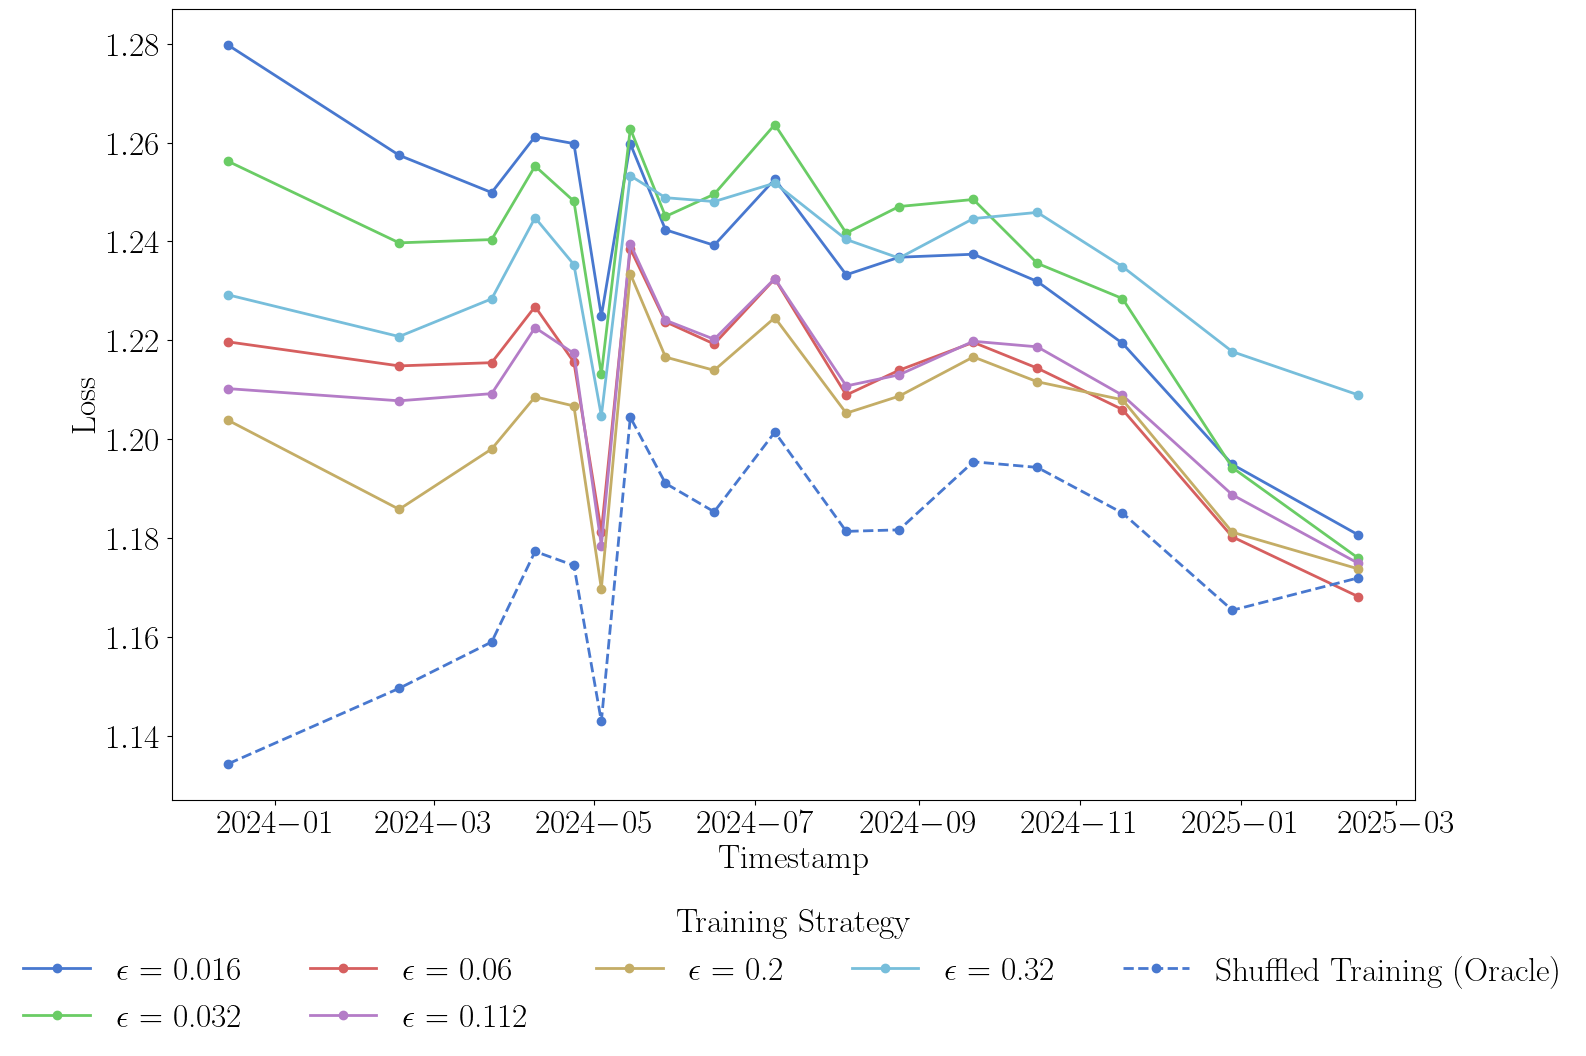

In [27]:
plot_training_strategies_comparison(
    paths_with_labels= [
        ('/tmp/checkpoint_results2/loss/output_eps_0.016.json', '$\epsilon$ = 0.016'),
        ('/tmp/checkpoint_results2/loss/output_eps_0.032.json', '$\epsilon$ = 0.032'),
        ('/tmp/checkpoint_results2/loss/output_eps_0.06.json', '$\epsilon$ = 0.06'),
        ('/tmp/checkpoint_results2/loss/output_eps_0.112.json', '$\epsilon$ = 0.112'),
        ('/tmp/checkpoint_results2/loss/output_eps_0.2.json', '$\epsilon$ = 0.2'),
        ('/tmp/checkpoint_results2/loss/output_eps_0.32.json', '$\epsilon$ = 0.32'),
        ('checkpoint_results/shuffled_cp_results.json', 'Shuffled Training (Oracle)'),


    ],
    title = 'Comparison of Replay Buffer Performance on Chronological Validation Data',
    ncols = 5
)

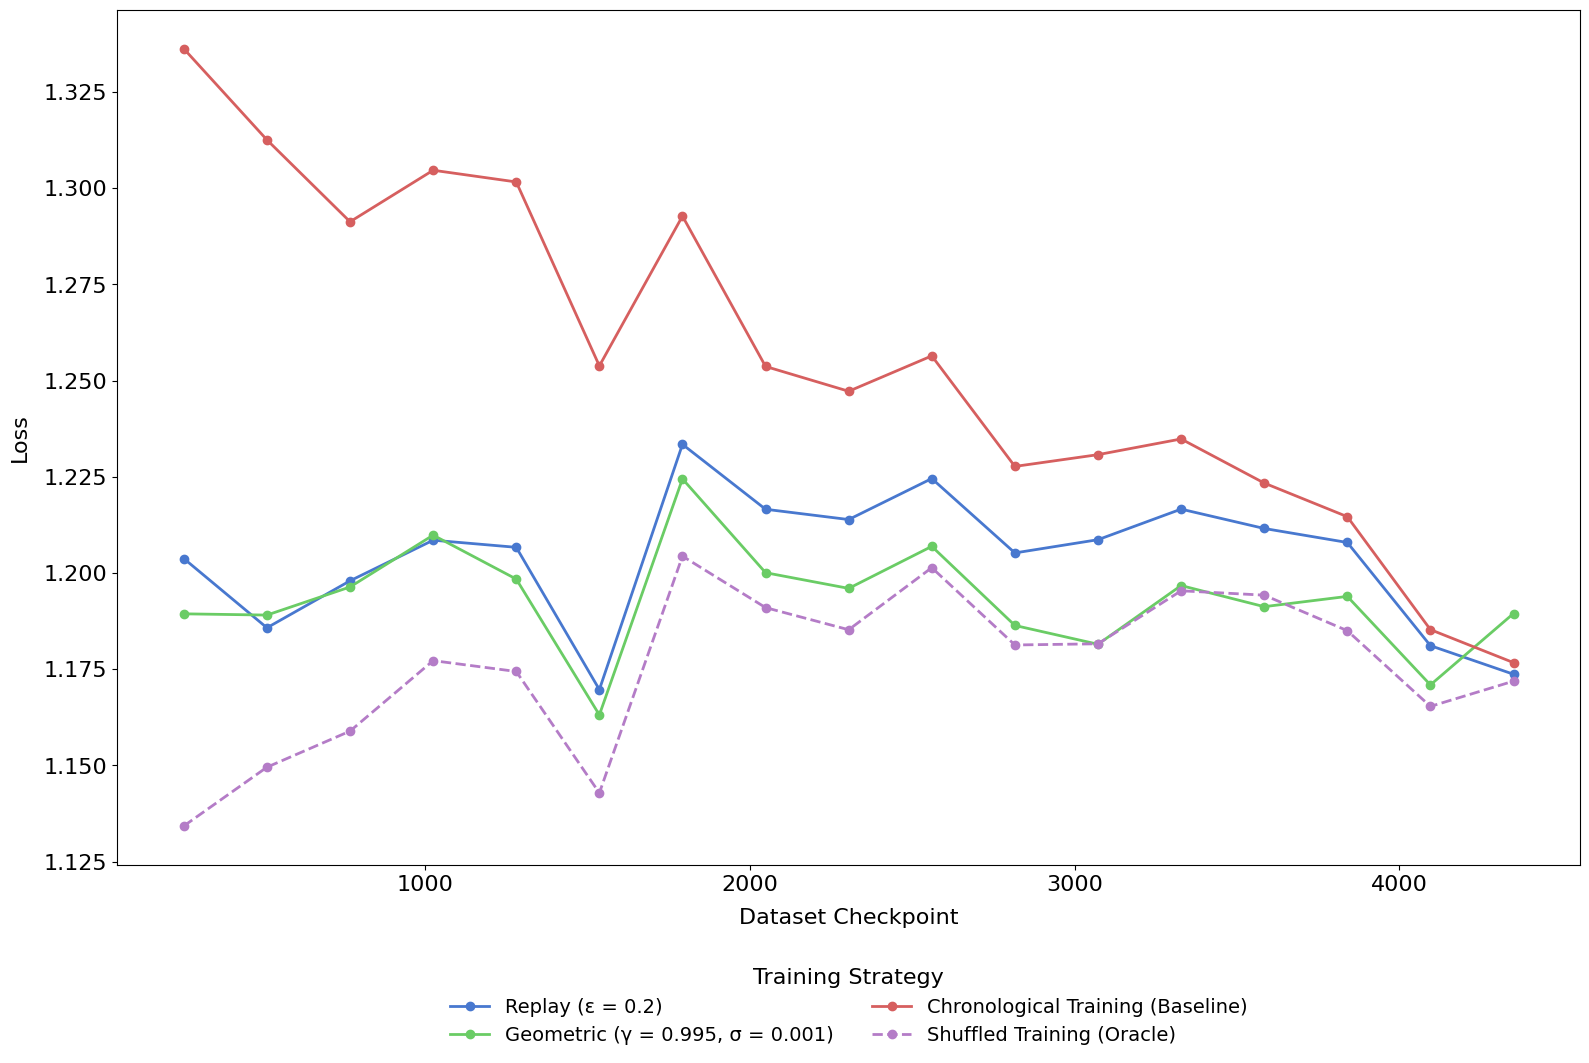

In [ ]:
plot_training_strategies_comparison(
    paths_with_labels= [
        ('checkpoint_results2/loss/output_eps_0.2.json', 'Replay (ε = 0.2)'),
        ('checkpoint_results2/loss/output-geom-0.995-0.001.json', 'Geometric (γ = 0.995, η = 0.001)'),
        ('checkpoint_results/naive_chrono_results.json', 'Chronological Training (Baseline)'),
        ('checkpoint_results/shuffled_cp_results.json', 'Shuffled Training (Oracle)')
    ],
    ncols = 2
)

In [20]:
plot_cp_results('checkpoint_results/naive_chrono_results.json', 'eval_plots2', 'naive_chrono_results', 'Chronological Baseline Loss Across Model and Dataset Checkpoints')

In [17]:
def plot_multiple_jsons(json_paths, tstamp_files, labels):
    assert len(json_paths) == len(labels), "Each JSON path must have a corresponding label"

    plt.figure(figsize=(10, 6))

    for path, tstamp_file, label in zip(json_paths, tstamp_files, labels):
        with open(path, 'r') as file:
            data = json.load(file)
            
        with open(tstamp_file, 'r') as file:
            tstamp_file = json.load(file)
        
        x_vals = sorted([int(cp) for cp in data.keys()])
        tstamps = [tstamp_file[str(cp)] for cp in x_vals]
        y_vals = [np.mean(list(data[str(cp)].values())) for cp in x_vals]

        plt.plot(tstamps, y_vals, marker='o', label=label)

    plt.xlabel("Checkpoint Number")
    plt.ylabel("Mean Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
json_files = [
    "/tmp/checkpoint_results2/loss/output-geom-0.995-0.001.json",
    "/tmp/checkpoint_results2/loss/output_eps_0.2.json",
]

tstamp_files = [
    "/tmp/timestamps/output-geom-0.995-0.001.json",
    "/tmp/timestamps/output_eps_0.2.json",
]

labels = [
    "Geometric Buffer (γ = 0.995, η = 0.001)",
    "Replay (ε = 0.2)",
]

plot_multiple_jsons(json_files, tstamp_files, labels)

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/timestamps/output-geom-0.995-0.001'

<Figure size 1000x600 with 0 Axes>

float